## GlucoTrack Project, Week Two, Feature Engineering

Objective: to work with a real-world CDC dataset and build a complete pipeline from data preprocessing to deployment using tools like PyTorch/TensorFlow, SHAP, and MLflow to glean insight for Diabetes risk factors.

Source: CDC Diabetes Health Indicators
- Outcome variable: Individuals are classified as diabetic (1) or non-diabetic (0)
- Features: Health, lifestyle, and demographic indicators. 
- All responses were obtained from phone surveys conducted as part of the CDC Behavioral Risk Factor Surveillance System (BRFSS). 
- Few questions represent objective lab measurements (cholesterol, high blood pressure); most are subjective measures of self-assessed health and lifestyle factors. 
- From the UCI repo, it looks like the data was collected in 2014
- Data collection methods can be found here and are an important part of the context of the representative nature of the potential findings to the general population:
https://www.cdc.gov/brfss/annual_data/2014/pdf/Overview_2014.pdf

In [3]:
import warnings
# Suppress specific warning categories
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', message='.*caveats.*')

# Core Libraries
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd

# Suppress pandas SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning
import sklearn
import xgboost as xgb
import lightgbm as lgb

# Experiment Tracking
import mlflow

# Deployment
import streamlit

# Utilities
#python-dotenv

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import shap
import time
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, RobustScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"MLflow version: {mlflow.__version__}")
print(f"SHAP version: {shap.__version__}")

Using device: cpu
Libraries imported successfully!
PyTorch version: 2.8.0+cpu
MLflow version: 3.2.0
SHAP version: 0.48.0


In [4]:
# Fetch the CDC Diabetes Health Indicators dataset
print("Fetching CDC Diabetes Health Indicators dataset...")
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# Extract features and target variables
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# Combine features and target into a single DataFrame for preprocessing
df = pd.concat([X, y], axis=1)

print(f"Dataset loaded successfully!")
print(f"Initial dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Fetching CDC Diabetes Health Indicators dataset...
Dataset loaded successfully!
Initial dataset shape: (253680, 22)
Memory usage: 42.58 MB


## **TASKS:**
- drop duplicate rows
- Split data into train/val/test with stratification
- handle class imbalance
- Encode high-cardinality categorical features with integer labels for embedding layers
- deal with outliers and skewed distribution
- feature scaling
- Convert datasets into PyTorch Dataloaders or TensorFlow tf.data objects

In [5]:
# Check for duplicate rows
print("=== DUPLICATE ROWS ===")
print(f"Original dataset rows: {df.shape[0]}")
print(f"Unique observations: {len(df.drop_duplicates())}")
print(f"Duplicate rows: {len(df) - len(df.drop_duplicates())}")

# Remove duplicate rows
df_clean = df.drop_duplicates()

print(f"\nAfter removing duplicates:")
print(f"Cleaned dataset rows: {df_clean.shape[0]}")
print(f"Rows removed: {len(df) - len(df_clean)}")

=== DUPLICATE ROWS ===
Original dataset rows: 253680
Unique observations: 229474
Duplicate rows: 24206

After removing duplicates:
Cleaned dataset rows: 229474
Rows removed: 24206


### **Optimize data types for memory efficiency**

I will follow Bankole's approach for optimization of data types for memory efficiency. 

In [6]:
# Analyze current data types
print("=== DATA TYPE OPTIMIZATION ===")
print("Current data types:")
print(df_clean.dtypes.value_counts())

# Check for float columns that could be integers
print("\nAnalyzing float columns for potential integer conversion:")
float_columns = df_clean.select_dtypes(include=['float64']).columns

for col in float_columns:
    # Check if all values are whole numbers
    if df_clean[col].apply(lambda x: x.is_integer()).all():
        print(f"  {col}: Can be converted to integer (all values are whole numbers)")
        df_clean[col] = df_clean[col].astype('int32')
    else:
        print(f"  {col}: Must remain float (contains decimal values)")
        # Check range to determine if int32 or int64 is appropriate
        min_val, max_val = df_clean[col].min(), df_clean[col].max()
        print(f"    Range: {min_val} to {max_val}")

# Optimize integer columns
int_columns = df_clean.select_dtypes(include=['int64']).columns
for col in int_columns:
    min_val, max_val = df_clean[col].min(), df_clean[col].max()
    if min_val >= 0 and max_val <= 255:
        df_clean[col] = df_clean[col].astype('uint8')
        print(f"  {col}: Optimized to uint8 (range: {min_val}-{max_val})")
    elif min_val >= -128 and max_val <= 127:
        df_clean[col] = df_clean[col].astype('int8')
        print(f"  {col}: Optimized to int8 (range: {min_val}-{max_val})")
    elif min_val >= 0 and max_val <= 65535:
        df_clean[col] = df_clean[col].astype('uint16')
        print(f"  {col}: Optimized to uint16 (range: {min_val}-{max_val})")
    else:
        df_clean[col] = df_clean[col].astype('int32')
        print(f"  {col}: Optimized to int32 (range: {min_val}-{max_val})")

print(f"\nMemory usage after optimization: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Memory reduction: {((df.memory_usage(deep=True).sum() - df_clean.memory_usage(deep=True).sum()) / df.memory_usage(deep=True).sum() * 100):.2f}%")

=== DATA TYPE OPTIMIZATION ===
Current data types:
int64    22
Name: count, dtype: int64

Analyzing float columns for potential integer conversion:
  HighBP: Optimized to uint8 (range: 0-1)
  HighChol: Optimized to uint8 (range: 0-1)
  CholCheck: Optimized to uint8 (range: 0-1)
  BMI: Optimized to uint8 (range: 12-98)
  Smoker: Optimized to uint8 (range: 0-1)
  Stroke: Optimized to uint8 (range: 0-1)
  HeartDiseaseorAttack: Optimized to uint8 (range: 0-1)
  PhysActivity: Optimized to uint8 (range: 0-1)
  Fruits: Optimized to uint8 (range: 0-1)
  Veggies: Optimized to uint8 (range: 0-1)
  HvyAlcoholConsump: Optimized to uint8 (range: 0-1)
  AnyHealthcare: Optimized to uint8 (range: 0-1)
  NoDocbcCost: Optimized to uint8 (range: 0-1)
  GenHlth: Optimized to uint8 (range: 1-5)
  MentHlth: Optimized to uint8 (range: 0-30)
  PhysHlth: Optimized to uint8 (range: 0-30)
  DiffWalk: Optimized to uint8 (range: 0-1)
  Sex: Optimized to uint8 (range: 0-1)
  Age: Optimized to uint8 (range: 1-13)
  

**A reminder of the target outcome class imbalance:**

In [7]:
print(len(df_clean[df_clean["Diabetes_binary"] == 1]), "patients marked diabetic/prediabetic and", len(df_clean[df_clean["Diabetes_binary"] == 0]), "patients marked no diabetes")
print(len(df_clean[df_clean["Diabetes_binary"] == 0])/ len(df_clean[df_clean["Diabetes_binary"] == 1]), "controls for each patient marked diabetic/prediabetic")

35097 patients marked diabetic/prediabetic and 194377 patients marked no diabetes
5.538279625039177 controls for each patient marked diabetic/prediabetic


In [8]:
# Separate de-dup data set into features and target
X_clean = df_clean.drop('Diabetes_binary', axis=1)
y_clean = df_clean['Diabetes_binary']

### **Create BMI Classification Categories**

I will follow Noora's suggestions to create BMI classifications based on WHO criteria. The results show a realistic population distribution with Normal (25.64%) and Overweight (36.05%) being the largest categories, followed by Obesity Classes I-III (36.98% combined), aligning with US population health statistics. I hope this categorization will improve the performance of the neural network model performance compared to initial tests using continuous values.

In [9]:
def create_bmi_categories(bmi_values):
    """
    Create WHO standard BMI categories from numerical BMI values.
    
    Categories:
    - 0: Underweight (< 18.5)
    - 1: Normal (18.5 - 24.9)
    - 2: Overweight (25.0 - 29.9)
    - 3: Obesity Class I (30.0 - 34.9)
    - 4: Obesity Class II (35.0 - 39.9)
    - 5: Obesity Class III (>= 40.0)
    """
    categories = np.zeros(len(bmi_values), dtype=int)
    
    # Define BMI thresholds
    categories[bmi_values < 18.5] = 0  # Underweight
    categories[(bmi_values >= 18.5) & (bmi_values < 25.0)] = 1  # Normal
    categories[(bmi_values >= 25.0) & (bmi_values < 30.0)] = 2  # Overweight
    categories[(bmi_values >= 30.0) & (bmi_values < 35.0)] = 3  # Obesity Class I
    categories[(bmi_values >= 35.0) & (bmi_values < 40.0)] = 4  # Obesity Class II
    categories[bmi_values >= 40.0] = 5  # Obesity Class III
    
    return categories

# Apply BMI categorization
print("=== BMI CATEGORIZATION ===")
print("Original BMI statistics:")
print(X_clean['BMI'].describe())

# Create BMI categories
X_engineered = X_clean.copy()
X_engineered['bmi_category'] = create_bmi_categories(X_clean['BMI'])

# Display BMI category distribution
bmi_cat_names = ['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III']
bmi_cat_counts = pd.Series(X_engineered['bmi_category']).value_counts().sort_index()

print("\nBMI Category Distribution:")
for i, (count) in enumerate(bmi_cat_counts):
    percentage = (count / len(X_engineered)) * 100
    print(f"  {i} ({bmi_cat_names[i]}): {count:,} ({percentage:.2f}%)")

=== BMI CATEGORIZATION ===
Original BMI statistics:
count    229474.000000
mean         28.687507
std           6.789204
min          12.000000
25%          24.000000
50%          27.000000
75%          32.000000
max          98.000000
Name: BMI, dtype: float64

BMI Category Distribution:
  0 (Underweight): 3,052 (1.33%)
  1 (Normal): 58,842 (25.64%)
  2 (Overweight): 82,723 (36.05%)
  3 (Obesity I): 50,693 (22.09%)
  4 (Obesity II): 20,448 (8.91%)
  5 (Obesity III): 13,716 (5.98%)


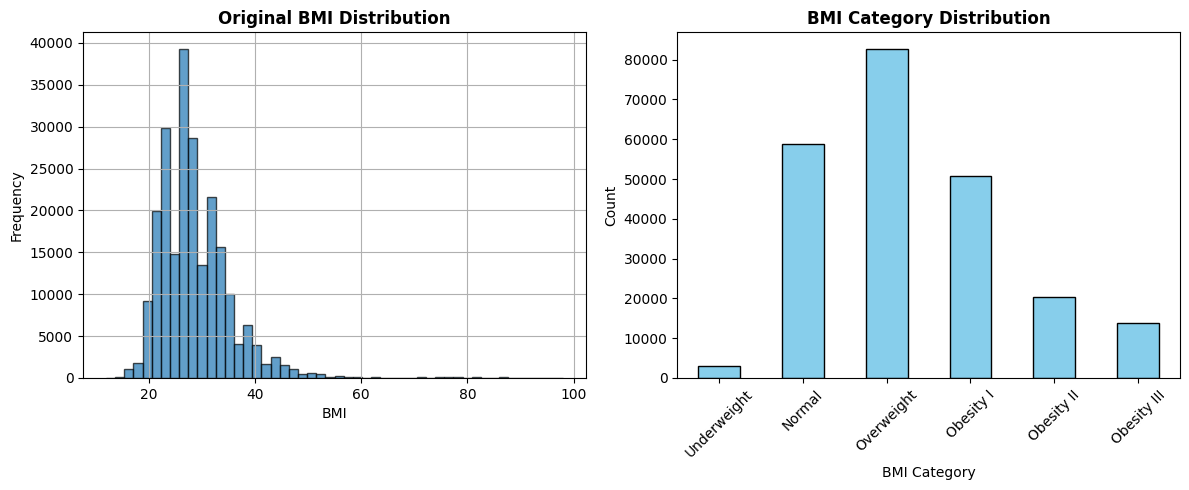


BMI Categories vs Diabetes Risk:
Diabetes_binary      0      1
bmi_category                 
0                94.46   5.54
1                93.36   6.64
2                87.23  12.77
3                79.89  20.11
4                72.35  27.65
5                66.41  33.59


In [10]:
# Visualize BMI category distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
X_clean['BMI'].hist(bins=50, alpha=0.7, edgecolor='black')
plt.title('Original BMI Distribution', fontweight='bold')
plt.xlabel('BMI')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
bmi_cat_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('BMI Category Distribution', fontweight='bold')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.xticks(range(6), bmi_cat_names, rotation=45)

plt.tight_layout()
plt.show()

# Analyze BMI categories vs diabetes target
print("\nBMI Categories vs Diabetes Risk:")
bmi_diabetes_crosstab = pd.crosstab(X_engineered['bmi_category'], y_clean, normalize='index') * 100
print(bmi_diabetes_crosstab.round(2))

**Which categorical features in the dataset have more than two unique values?**

In [11]:
categorical_cols = []
for col in X_engineered.columns:
    if (X_engineered[col].dtype == 'object' or X_engineered[col].dtype.name == 'category' or X_engineered[col].nunique() < 20) and X_engineered[col].nunique() > 2:
        categorical_cols.append(col)
print(categorical_cols)

['GenHlth', 'Age', 'Education', 'Income', 'bmi_category']


In [12]:
X_engineered = X_engineered.drop(columns=['BMI'])

**Apply integer-encoding to the high-cardinality features ('GenHlth', 'Age', 'Education', 'Income', and the newly engineered 'bmi_category').**

**Why? Integer-encoding transforms categories into integer indices, which can be used as inputs to an embedding layer. Embedding layers map these indices to dense, learnable vector representations, allowing the model to capture relationships between categories efficiently—especially useful for high-cardinality features. This approach avoids the dimensionality explosion of one-hot encoding and enables the network to learn similarities between categories.**

In [13]:
for col in categorical_cols:
    X_engineered[col] = X_engineered[col].astype('category').cat.codes

In [14]:
X_engineered.head()

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,bmi_category
0,1,1,1,1,0,0,0,0,1,0,...,0,4,18,15,1,0,8,3,2,5
1,0,0,0,1,0,0,1,0,0,0,...,1,2,0,0,0,0,6,5,0,2
2,1,1,1,0,0,0,0,1,0,0,...,1,4,30,30,1,0,8,3,7,2
3,1,0,1,0,0,0,1,1,1,0,...,0,1,0,0,0,0,10,2,5,2
4,1,1,1,0,0,0,1,1,1,0,...,0,1,3,0,0,0,10,4,3,1


**Create a final X/y dataset representing dropped duplicate observations, engineered BMI feature and high-cardinality encoded features to do the train/test split with test_size=0.20 followed by a 2nd split for a validation subset, and with stratification parameter set to True in both splits.**

Note we will yield the following:
60% train (0.8 * 0.8)
20% validation (0.8 * 0.25)
20% test

**Stratification is critical for this dataset because the target variable (Diabetes_binary) is highly imbalanced—there are many more non-diabetic than diabetic cases.**

- prevents random splitting that could result in training, validation, or test sets that do not accurately reflect true class proportions
- more reliable model evaluation and generalization
- ensures each subset maintains the same class distribution as the original data, 
- more meaningful performance metrics, especially for the minority class.

In [15]:
X_final = X_engineered.copy()
y_final = y_clean.copy()

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_final, y_final, test_size=0.2, stratify=y_final, random_state=42
)

# split the remaining data into training and validation sets (e.g., 80/20 of the remaining)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)

In [16]:
# 4. Apply SMOTE to the training data ONLY
# This step is crucial for addressing class imbalance without data leakage.
from imblearn.over_sampling import SMOTE 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

**Transform non-binary features and check the distribution after scaling**

**Robust scaling was recommended because several features (such as BMI, Age, Education, and Income) have outliers or skewed distributions. Unlike standard scaling, RobustScaler uses the median and interquartile range (IQR) instead of the mean and standard deviation, making it less sensitive to extreme values. This helps ensure that outliers do not disproportionately influence the scaling, resulting in more stable and reliable feature values for modeling.**

**Code check recommends no further scaling for the integer-encoded features**

In [17]:
# Feature transformations: Select continuous and ordinal columns (excluding binary and target)
continuous_cols = ['MentHlth', 'PhysHlth']

# Robust scaling to reduce outlier impact
scaler = RobustScaler()

# Replace original columns with transformed values in your dataframe
X_train_resampled[continuous_cols] = scaler.fit_transform(X_train_resampled[continuous_cols])


# Transform the validation and test data using the fitted scaler
X_val[continuous_cols] = scaler.transform(X_val[continuous_cols])
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

# Convert the scaled NumPy arrays back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_resampled, columns=X_train_resampled.columns)
X_val_scaled = pd.DataFrame(X_val, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test, columns=X_test.columns)

**Summary statistics of scaled data compared to pre-scaled data and distribution plots for the scaled features:**

In [18]:
print("Scaled continuous features:")
print(X_train_scaled[continuous_cols].describe())
print("Original continuous features:")
print(df_clean[continuous_cols].describe())

Scaled continuous features:
            MentHlth       PhysHlth
count  233252.000000  233252.000000
mean        1.294628       0.852740
std         2.759805       1.448567
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         1.000000       1.000000
max        10.000000       4.285714
Original continuous features:
            MentHlth       PhysHlth
count  229474.000000  229474.000000
mean        3.509866       4.681219
std         7.717643       9.050877
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         2.000000       4.000000
max        30.000000      30.000000


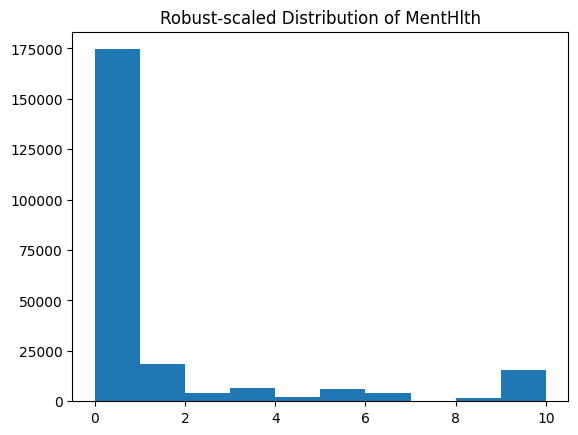

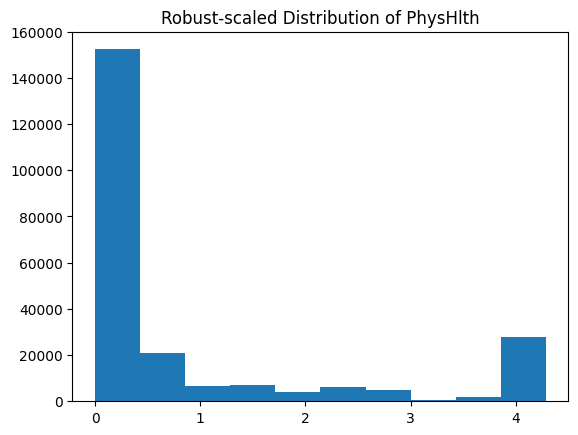

In [19]:
for col in continuous_cols:
    plt.hist(data=X_train_scaled, x= col)
    plt.title(f'Robust-scaled Distribution of {col}')
    plt.xticks(rotation=0)
    plt.show()

**Verify class distribution between subsets: train set should be balanced while the others should remain with the original proportions**

In [20]:
print("Train set class distribution:")
print(y_train_resampled.value_counts(normalize=True))

print("\nValidation set class distribution:")
print(y_val.value_counts(normalize=True))

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

Train set class distribution:
Diabetes_binary
1    0.5
0    0.5
Name: proportion, dtype: float64

Validation set class distribution:
Diabetes_binary
0    0.847042
1    0.152958
Name: proportion, dtype: float64

Test set class distribution:
Diabetes_binary
0    0.847064
1    0.152936
Name: proportion, dtype: float64


**Now we can prepare objects for pytorch models**

**Batch size 64 was selected as it is a practical, widely used choice for tabular data, offering a good trade-off between speed, stability, and resource usage.**

**We set shuffle=True for train_loader to ensure that the training data is randomly shuffled at the start of each epoch.**

- Prevents the model from learning the order of the data, which could lead to overfitting or poor generalization
- Improves convergence by exposing the model to a different data order each epoch, helping it learn more robust patterns

**For the validation and test sets, shuffle=False is used because:**

- Evaluation should be deterministic - to measure performance on the exact same data in the same order each time.

In [21]:
# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
# Change .squeeze() to .unsqueeze(1) to ensure the target tensor has shape (N, 1)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Convert balanced validation set to torch tensors
X_val_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Now train_loader and test_loader are ready for PyTorch models

**Retrieve a batch from training DataLoader**

The shape of the batch is as expected with batch size of 64 and 21 features

In [22]:
batch_X, batch_y = next(iter(train_loader))
print("Features shape:", batch_X.shape)
print("Labels shape:", batch_y.shape)

Features shape: torch.Size([64, 21])
Labels shape: torch.Size([64, 1])


## **NEXT STEPS**

- Set up and test a Feed Forward Neural Network and tune hyperparameters.